# MEPs in diseased vs healthy mice

In [1]:
from tqdm import tqdm
from mepextract.extracting import Extractor
from scipy.signal import find_peaks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import os
import pickle
import json

plt.style.use(['science', 'grid', 'custom', 'vibrant'])

## defining relevant folders and paths

In [2]:
spreadsheet = pd.read_csv('/Users/fomo/Documents/Research/UNIC Research/Motor Evoked Potentials Test/mep_sciatic.csv')

# master_folder = '/Volumes/STORAGE 1.0/UNIC Research/Motor Evoked Potentials/motor_evoked_potentials_dataspell/MEPSSEP_raw_data'

master_folder = '/Users/fomo/Documents/Research/UNIC Research/Motor Evoked Potentials Test'

spreadsheet.head()

,index,session,animalID,cage,ear,phenotype,phenoCode,subrec,sessionClass,sessionType,currentLevel,isoflo,stim,trials_from,trials_to,notes,session_dates
0,37,2024-03-02 11:08:17,A565,NaN,NaN,5XFAD,2.0,1,MEP,sciatic,1.68,1.60,NaN,1.0,60.0,1 pulse 100us,2024-03-02_11-08-17
1,42,2024-03-02 12:39:39,A580,NaN,NaN,5XFAD,2.0,1,MEP,sciatic,1.20,1.75,NaN,NaN,NaN,21pulses 100us pol black,2024-03-02_12-39-39
2,50,2024-03-02 14:50:32,A563,NaN,NaN,WT,1.0,1,MEP,sciatic,1.05,1.75,NaN,NaN,NaN,50us pulse,2024-03-02_14-50-32
3,51,2024-03-02 15:25:14,A579,NaN,NaN,WT,1.0,1,MEP,sciatic,0.65,NaN,NaN,NaN,NaN,ref on base of tail .65mA 100us single pulse,2024-03-02_15-25-14
4,58,2024-03-02 17:19:10,A585,NaN,NaN,WT,1.0,1,MEP,sciatic,3.00,1.75,NaN,NaN,NaN,100us pulse single iso=1.75% ref on tail,2024-03-02_17-19-10


## extracting MEPs for all trials

In [25]:
# number of trials to iterate over
n = 1
sampling_rate = 30000

extracted_peaks = []

for i in tqdm(range(0, n), desc="Processing trials"):
    
    # trial name
    trial = spreadsheet.session_dates[i]
    
    # marking disease status
    if spreadsheet.phenotype[i] == 'WT':
        phenotype = 0
    else:
        phenotype = 1
        
    # marking current amplitude
    current_amplitude = spreadsheet.currentLevel[i]

    # defining search parameters
    channels = [5,6,7,8]
    search_parameters = {'height': 10, 'width': (60, 90), 'distance': 30, 'prominence': 2}
    
    # defining extractor object
    extractor = Extractor(master_folder=master_folder, trial=trial, group=phenotype, recording_channels=channels)
    
    extractor.pre_stimulus = 300
    extractor.post_stimulus = 3000
    
    extractor.notes = spreadsheet.loc[i]
    
    extractor.extract_raw()
    extractor.extract_events(event_channel_number=13)
    extractor.get_event_data(export=False)
    
    detected = {'trial': trial, 'phenotype': phenotype, 'current': current_amplitude, 'data': extractor.mep}

    extracted_peaks.append(detected)

Processing trials: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Positive peaks: [341 422]
Negative peaks: [313]
Positive peaks: [367 390 495]
Negative peaks: []


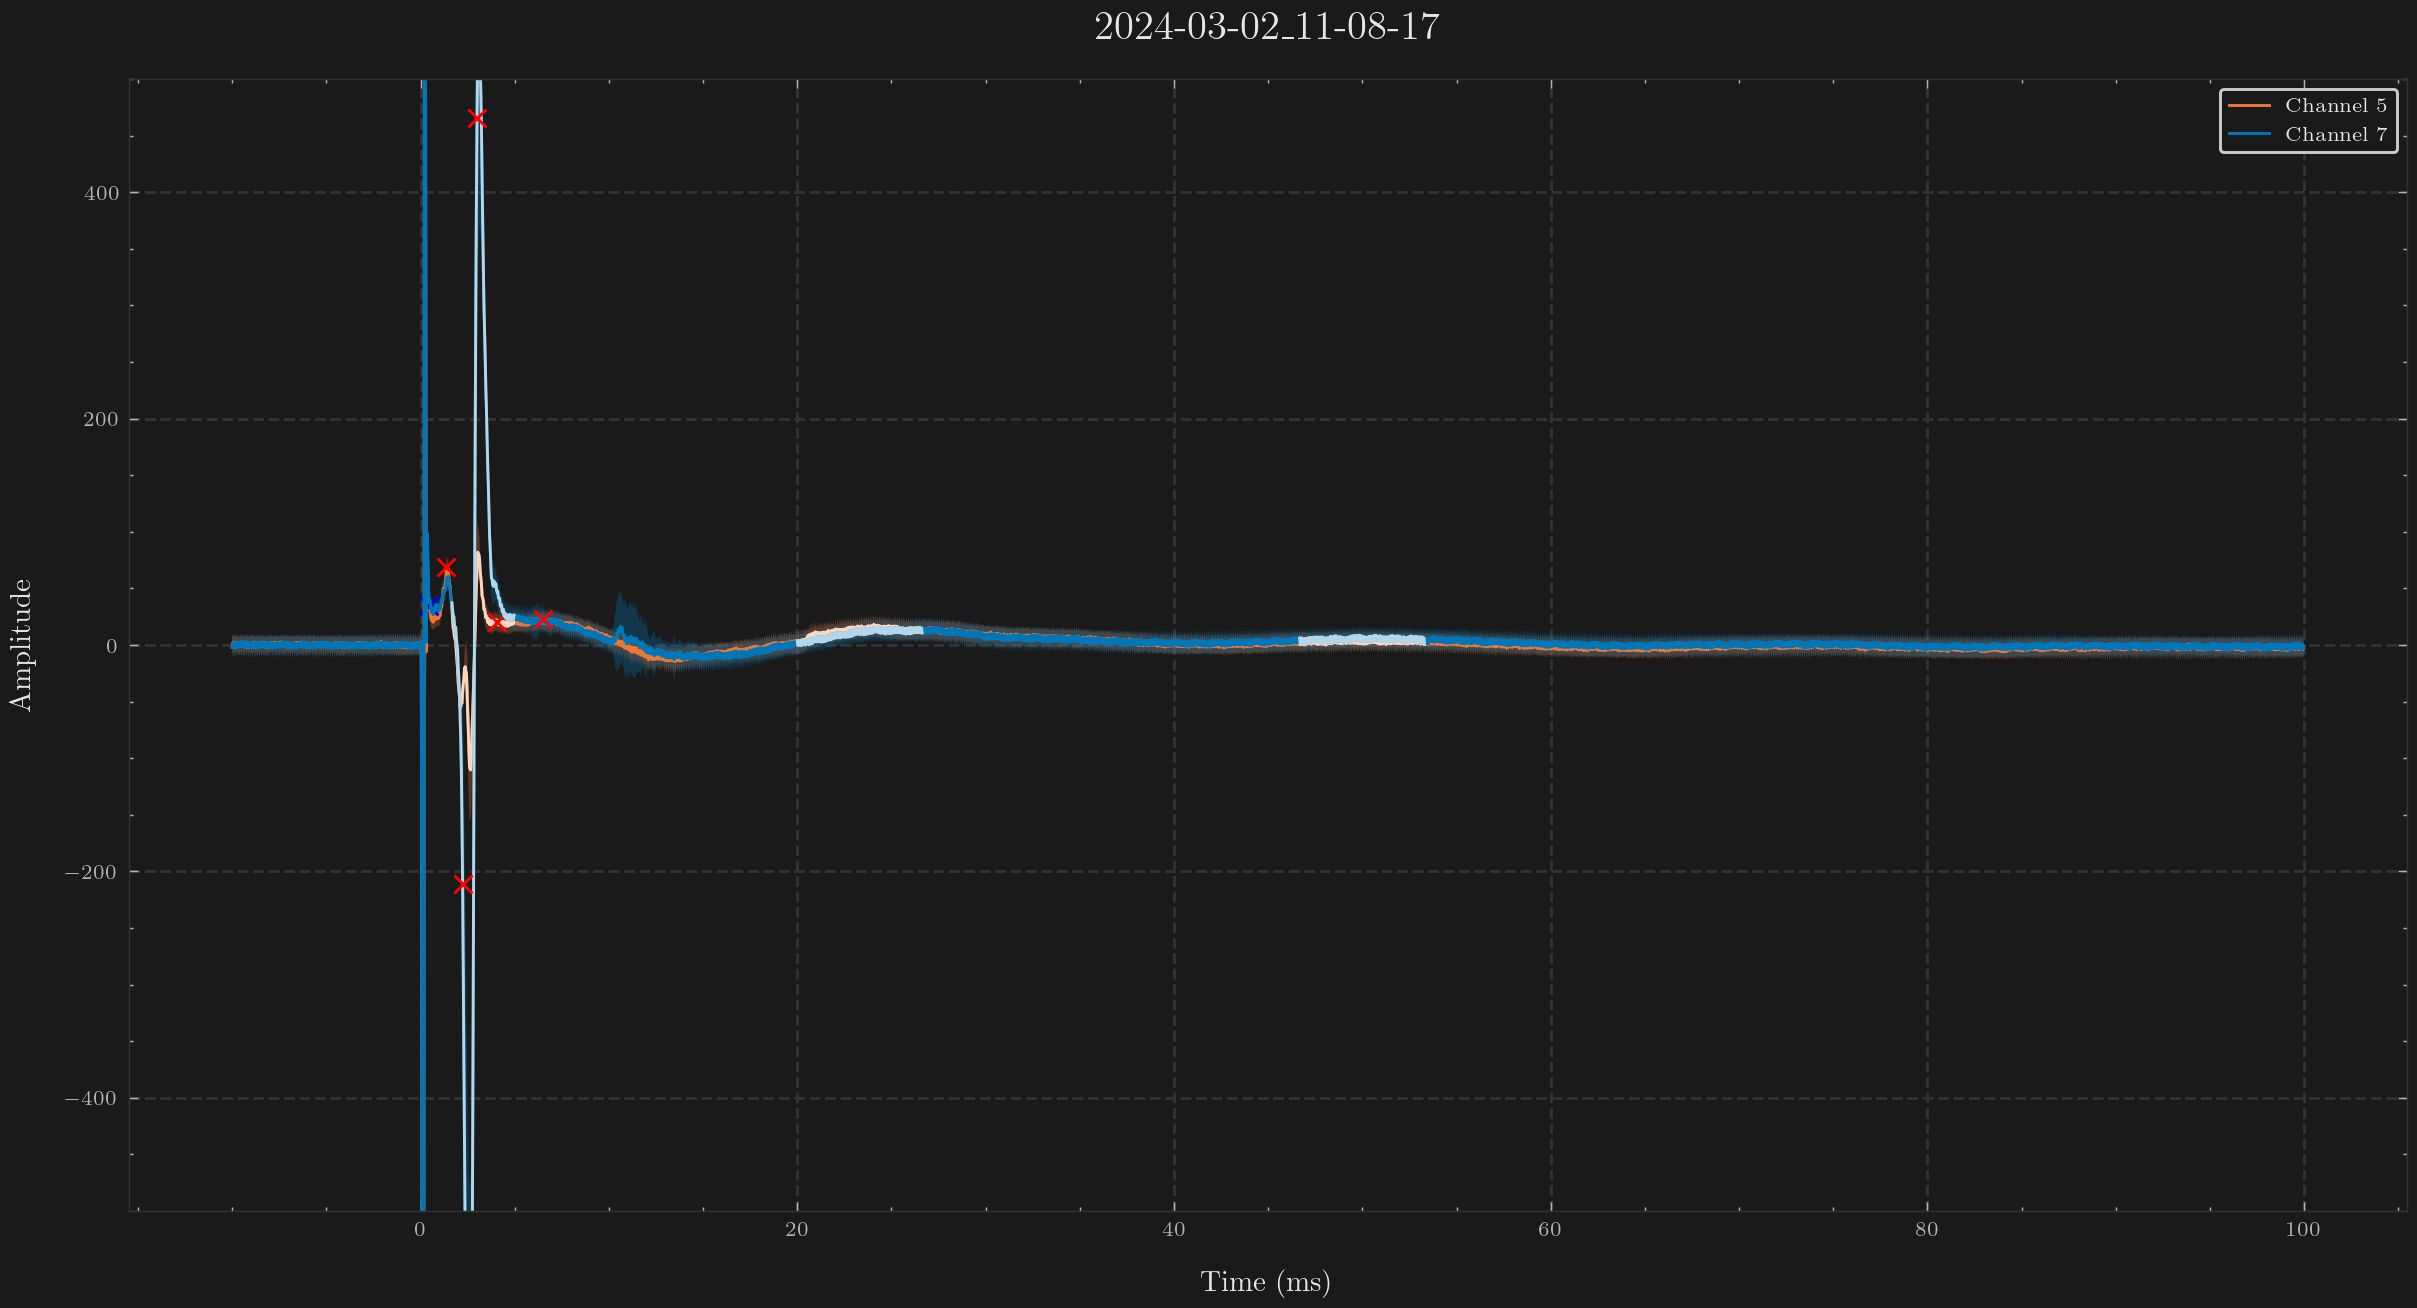

In [63]:
temp = extracted_peaks[0]['data']

recording_channels = [5,7]

conversion = 1000 / sampling_rate

time_axis = np.arange(-300, 3000) * conversion

axis = np.arange(3300)

pre = 300
zone1 = axis[50:150] + pre
zone2 = axis[600:800] + pre
zone3 = axis[1400:1600] + pre

plt.figure(figsize=(14, 7), dpi=210)

for channel in recording_channels:
    # calculating baseline correction
    correction_value = temp[channel, :300, :].mean(axis=1).mean(axis=0)
    correction = np.full((1, 3300), correction_value)
    
    # subtracting baseline correction from mean and std
    mean = (temp[channel, :, :].mean(axis=1) - correction).flatten()
    std = (temp[channel, :, :].std(axis=1) - correction).flatten()
    
    # find meps
    search = {'height': (10, 100), 'width': None, 'distance': 100}
    
    peaks_1_positive, _ = find_peaks(
        mean[zone1], 
        height = search['height'],
        width = search['width'],
        distance = search['distance']
    )
    peaks_2_positive, _ = find_peaks(
        mean[zone2],
        height = search['height'],
        width = search['width'],
        distance = search['distance']
    )
    peaks_3_positive, _ = find_peaks(
        mean[zone3],
        height = search['height'],
        width = search['width'],
        distance = search['distance']
    )

    positive_peaks = np.concatenate((peaks_1_positive, peaks_2_positive, peaks_3_positive))+pre
    print(f'Positive peaks: {positive_peaks}')
    
    peaks_1_negative, _ = find_peaks(
        -mean[zone1], 
        height = search['height'],
        width = search['width'],
        distance = search['distance']
    )
    peaks_2_negative, _ = find_peaks(
        -mean[zone2],
        height = search['height'],
        width = search['width'],
        distance = search['distance']
    )
    peaks_3_negative, _ = find_peaks(
        -mean[zone3],
        height = search['height'],
        width = search['width'],
        distance = search['distance']
    )
    
    negative_peaks = np.concatenate((peaks_1_negative, peaks_2_negative, peaks_3_negative))+pre
    print(f'Negative peaks: {negative_peaks}')
    
    # plotting mean and std
    plt.plot(time_axis, mean, label=f'Channel {channel}')
    plt.fill_between(time_axis, mean - std, mean + std, alpha=0.3)
    
    plt.plot(time_axis[zone1], mean[zone1], color='white', alpha=0.7)
    plt.plot(time_axis[zone2], mean[zone2], color='white', alpha=0.7)
    plt.plot(time_axis[zone3], mean[zone3], color='white', alpha=0.7)
    
    # plotting detected peaks
    plt.plot(time_axis[positive_peaks], mean[positive_peaks], 'x', color='red')
    plt.plot(time_axis[negative_peaks], mean[negative_peaks], 'x', color='blue')

plt.title(extracted_peaks[0]['trial'])
plt.ylim(-500, 500)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.legend()



## plotting detected peaks